# HW 2

Due 3/24/22

In [75]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.utils.data as Data

In [91]:
# Set plot parameters for entire notebook
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['font.size'] = 10

## 1.1 Data preprocessing

The CSV file should be in the same directory as this notebook. Otherwise, update the file_name path.

References:
* https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

### 1.1.1 Read CSV and define variable categories

In [2]:
file_name = './Untitled spreadsheet - Terres_Li_Sample_Data_Set.csv'
df = pd.read_csv(file_name)

In [3]:
# Independent variables
indep_vars = ['Bx', 'By', 'Bz', 'Bmag_avg', 'Ni_avg', 'Vx', 'Vy', 'Vz', 'VSW', 
'Vth_mag_Ion', 'Vth_para_Ion', 'Vth_perp_Ion', 'Ne', 'Ue', 'Te', 'Ti', 'Ti_para', 
'Ti_perp']

# Derived variables: from independent variables using formulas
deriv_vars = ['VA', 'Beta', 'Beta_para', 'Beta_perp', 'Omega_i', 'omega_pi', 
'omega_pe', 'rho_i', 'rho_s', 'd_i', 'd_e', 'sigma_i', 'Lperp', 'lambda_d']

# Dependent variable: target
dep_var = ['k_brk']

# Check that the number of variables in each category are as expected
print(len(indep_vars), len(deriv_vars), len(dep_var))

18 14 1


In [4]:
# Convert Pandas dataframes to PyTorch tensors
indep = torch.tensor(df[indep_vars].values)
deriv = torch.tensor(df[deriv_vars].values)
dep = torch.tensor(df[dep_var].values)

### 1.1.2 Visualize the input data

In [83]:
# Visualize the input data
def plot_many(xs, y, xs_names, num_cols=6, title='', size=(8, 7), fontsize=8):
    num_plots = len(xs_names)
    num_rows = int(num_plots / num_cols) + 1
    plt.subplots(figsize=size)
    plt.suptitle(title, fontsize=fontsize*1.5)

    # For each variable in x
    for i in range(num_plots):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.plot(xs[:, i], y, '.', alpha=0.5)
        plt.title(xs_names[i], fontsize=fontsize*1.2, y=1.1)
        plt.ticklabel_format(style='sci', scilimits=(-3, 4), axis='x')

    plt.tight_layout()

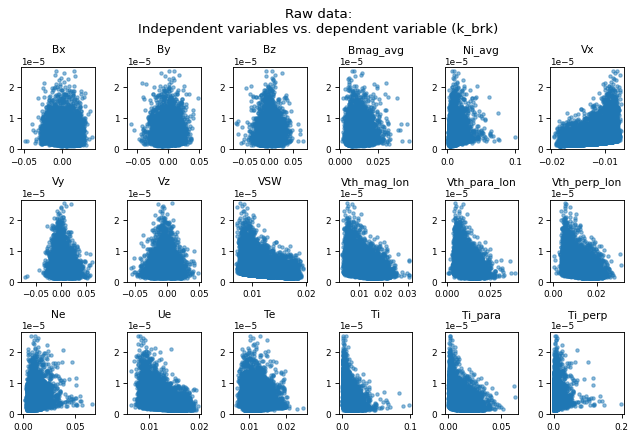

In [84]:
plot_many(indep, dep[:, 0], indep_vars, 
    title='Raw data:\nIndependent variables vs. dependent variable (k_brk)')

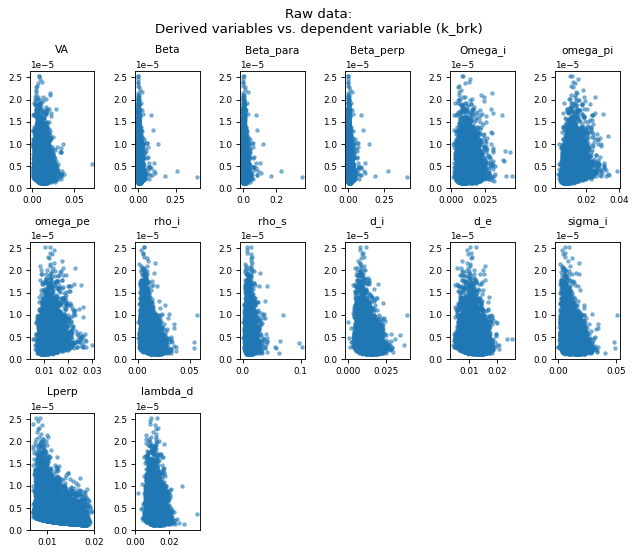

In [81]:
plot_many(deriv, dep[:, 0], deriv_vars,
    title='Raw data:\nDerived variables vs. dependent variable (k_brk)')

### 1.1.3 Prepare for feeding into network

In [8]:
# Normalize the input data for each variable
indep = torch.nn.functional.normalize(indep, dim=0)
deriv = torch.nn.functional.normalize(deriv, dim=0)

# Create datasets
indep_dep = Data.TensorDataset(indep, dep)
deriv_dep = Data.TensorDataset(deriv, dep)

# Decide on training, validation, and testing splits
train_size = int(0.70 * len(df))
valid_size = int(0.15 * len(df)) + 1
test_size = len(df) - (train_size + valid_size)
splits = [train_size, valid_size, test_size]

print('Training, validation, testing:', splits)

# Split the data for both indep-dep pairs & derived-dep pairs
train_indep, valid_indep, test_indep = Data.random_split(indep_dep, splits)
train_deriv, valid_deriv, test_deriv = Data.random_split(deriv_dep, splits)

Training, validation, testing: [4923, 1055, 1055]


In [9]:
# Define dataloaders
batch_size = 32
train_loader_indep = Data.DataLoader(
    dataset=train_indep, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader_indep = Data.DataLoader(
    dataset=valid_indep, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_indep = Data.DataLoader(
    dataset=test_indep, batch_size=batch_size, shuffle=True, num_workers=2)

train_loader_deriv= Data.DataLoader(
    dataset=train_indep, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader_deriv = Data.DataLoader(
    dataset=valid_indep, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_deriv = Data.DataLoader(
    dataset=test_deriv, batch_size=batch_size, shuffle=True, num_workers=2)

## 1.2 Define classes and functions

References:
* https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

### 1.2.1 Network classes

In [10]:
# Neural network with one hidden layer
class Net1(nn.Module): 
    def __init__(self, num_features, num_hidden, num_output,
    batch_norm=True, p_dropout=0.2):
        super(Net1, self).__init__()
        
        # Define hidden and output layers
        layers = [nn.Linear(num_features, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_output)]
        
        # If desired, add batch normalization
        if batch_norm:
            layers.insert(-1, nn.BatchNorm1d(num_hidden))
        
        # If desired, add dropout
        if p_dropout > 0.0:
            layers.insert(-1, nn.Dropout(p_dropout))

        self.stack = nn.Sequential(*layers)
        
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [11]:
# Neural network with two hidden layers
class Net2(nn.Module): 
    def __init__(self, num_features, num_hiddens, num_output):
        super(Net2, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(num_features, num_hiddens[0]),
            nn.ReLU(),
            nn.BatchNorm1d(num_hiddens[0]),
            nn.Linear(num_features, num_hiddens[1]),
            nn.ReLU(),
            nn.BatchNorm1d(num_hiddens[1]),
            nn.Linear(num_hiddens[1], num_output)
        )
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [12]:
# Initialize parameters
# weights: Kaiming initialization
# biases: set to 0, as discussed in class
def init_parameters(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0) # Set bias to 0

### 1.2.2 Functions for training and testing

In [16]:
# Define train & test functions for one pass through the dataset (aka one epoch)
def train_loop(loader, model, loss_fun, optimizer):
    train_loss = 0.0

    # For each batch
    for X, y in loader:
        prediction = model(X) # forward pass
        loss = loss_fun(prediction, y) # compute loss
        train_loss += loss.item() # assume default reduction of 'mean'
        optimizer.zero_grad() # clear gradients for this loop
        loss.backward() # compute gradients
        optimizer.step() # apply gradients
    
    # Average over number of batches in the epoch
    return train_loss/len(loader)
    
def test_loop(loader, model, loss_fun):
    test_loss = 0.0

    # No backprop during validation/testing
    with torch.no_grad():
        for X, y in loader:
            prediction = model(X)
            test_loss += loss_fun(prediction, y).item()
    return test_loss/len(loader)

# Define functions to loop over many epochs
def train_epochs(train_loader, test_loader, model, loss_fun, optimizer, 
    epochs, verbose=False):
    train_losses = np.empty(epochs)
    test_losses = np.empty(epochs)

    # For each epoch
    for epoch in range(epochs):
        train_losses[epoch] = train_loop(train_loader, model.double(), 
            loss_fun, optimizer)
        test_losses[epoch] = test_loop(test_loader, model.double(), loss_fun)
    
        if verbose:
            print('epoch: {}\ttraining loss: {:.3e}'
            '\tvalidation loss: {:.3e}'.format(
                epoch, train_losses[epoch], test_losses[epoch]))
    
    return train_losses, test_losses

## 1.3 Independent &rarr; dependent variables

Create a model to relate the independent variables to the dependent variable.

In [51]:
# Standard mean squared error loss function
mse = nn.MSELoss(reduction='mean') # default reduction

# Create container to store models, optimizers, & results in
models = []

### 1.3.1 1 hidden layer

`model16`: 16 neurons in hidden layer
* batch normalization (using default value of `affine=True`, so learnable parameters)
* dropout (`p=0.2`)
* standard gradient descent (SGD) with learning rate `lr=0.1` and `momentum=0.9`. L2 regularization with lambda `weight_decay=1e-5`

`model8`: 8 neurons in hidden layer
*  Otherwise, same as `model16`

`model16_no_norm`: 16 neurons in hidden layer
* no batch normalization
* no dropout
* standard gradient descent (SGD) with learning rate `lr=0.1` and `momentum=0.9`. No regularizer added to loss.

`model8_no_norm`: 8 neurons in hidden layer
* Otherwise, same as `model16_no_norm`

In [52]:
model16 = Net1(len(indep_vars), 16, 1)
model16.apply(init_parameters)
models.append({
    'name': 'model16',
    'model': model16, 
    'opt': torch.optim.SGD(model16.parameters(), lr=0.1, 
        momentum=0.9, weight_decay=1e-5)})

model8 = Net1(len(indep_vars), 8, 1)
model8.apply(init_parameters)
models.append({
    'name': 'model8',
    'model': model8, 
    'opt': torch.optim.SGD(model8.parameters(), lr=0.1, 
        momentum=0.9, weight_decay=1e-5)})

model16_no_norm = Net1(len(indep_vars), 16, 1, batch_norm=False, p_dropout=0)
model16_no_norm .apply(init_parameters)
models.append({
    'name': 'model16_no_norm',
    'model': model16_no_norm, 
    'opt': torch.optim.SGD(model16_no_norm.parameters(), lr=0.1, momentum=0.9)})

model8_no_norm = Net1(len(indep_vars), 8, 1, batch_norm=False, p_dropout=0)
model8_no_norm .apply(init_parameters)
models.append({
    'name': 'model8_no_norm',
    'model': model8_no_norm,
    'opt': torch.optim.SGD(model8_no_norm.parameters(), lr=0.1, momentum=0.9)})

In [53]:
for _ in models:
    model = _['model']
    opt = _['opt']
    _['result'] = train_epochs(train_loader_indep, valid_loader_indep, model, 
        loss_fun=mse, optimizer=opt, epochs=5)

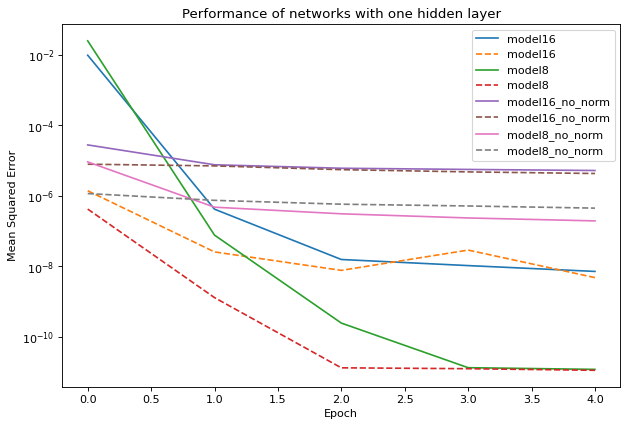

In [93]:
for m in models:
    # Plot training performance
    plt.plot(np.arange(m['result'][0].shape[0]), 
        m['result'][0], label=m['name'])
    
    # Plot validation performance
    plt.plot(np.arange(m['result'][1].shape[0]), 
        m['result'][1], '--', label=m['name'])
plt.title('Performance of networks with one hidden layer')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

## 1.4 Derived &rarr; dependent variables